In [ ]:
# File description: Loads and preprocesses the BDD100K dataset with custom bounding box annotations
import torch
import numpy
import pandas
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
class BDD100KDetectionDataset(Dataset):
    def __init__(self, image_dir, label_path, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.data = []
        
        with open(label_path, 'r') as f:
            self.labels = json.load(f)
            
        for item in self.labels:
            image_path = os.path.join(image_dir, item['name'])
            annotations = item.get('labels', [])
            self.data.append((image_path, annotations))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, annotations = self.data[idx]
        # Load image without conversion first to get original size
        original_image = Image.open(image_path)
        original_width, original_height = original_image.size
        
        # Convert to RGB for processing
        image = original_image.convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        # Get new resized image dimensions (defined in transforms.Resize)
        new_width, new_height = 256, 256  
        scale_x = new_width / original_width
        scale_y = new_height / original_height

        boxes = []
        labels = []
        for ann in annotations:
            bbox = ann.get('box2d', {})
            if bbox:
                # Rescale bounding box coordinates
                x1 = bbox['x1'] * scale_x
                y1 = bbox['y1'] * scale_y
                x2 = bbox['x2'] * scale_x
                y2 = bbox['y2'] * scale_y
                boxes.append([x1, y1, x2, y2])
                labels.append(ann.get('category', 'unknown'))

        return image, {
            "boxes": torch.tensor(boxes, dtype=torch.float32), 
            "labels": labels,
            "original_size": original_image.size  # Adding original size
        }

def collate_fn(batch):
    images = []
    targets = []
    for img, target in batch:
        images.append(img)
        targets.append(target)
    return images, targets


In [3]:
# Paths
IMAGE_DIR = "/Users/andrewpaolella/Desktop/Final-Project/BDD100k/bdd100k/bdd100k/images/100k/train"
LABEL_PATH = "/Users/andrewpaolella/Desktop/Final-Project/BDD100k/labels/det_v2_train_release.json"

In [ ]:
batch_size = 64

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
# Create datasets
training_data = BDD100KDetectionDataset(IMAGE_DIR, LABEL_PATH, transform=transform)
test_data = BDD100KDetectionDataset(IMAGE_DIR, LABEL_PATH, transform=transform)

# Limit dataset size
training_data.data = training_data.data[:512]
test_data.data = test_data.data[:128]

# Create DataLoaders
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Print information
print(f"Total samples in training set: {len(training_data)}")
print(f"Total samples in test set: {len(test_data)}")
print(f"Resized image size: 256x256 (defined in transforms.Resize)")


Total samples in training set: 512
Total samples in test set: 128
Resized image size: 256x256 (defined in transforms.Resize)


In [6]:
# Function to display a sample image with bounding boxes
def show_sample_with_boxes(image, target):
    fig, ax = plt.subplots(1, figsize=(8, 8))
    image_np = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy for display
    ax.imshow(image_np)

    for box, label in zip(target['boxes'], target['labels']):
        x1, y1, x2, y2 = box.tolist()
        width, height = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.show()




Batch information:
Number of images in batch: 8
Shape of processed image tensor [C,H,W]: torch.Size([3, 256, 256])
Original image size: 1280x720

Ground truths for first image:
Number of objects: 7
Bounding boxes (x1, y1, x2, y2):
Object 1:
  Category: traffic light
  Box coordinates: [225.18045043945312, 47.35448455810547, 231.39572143554688, 74.97793579101562]
Object 2:
  Category: traffic light
  Box coordinates: [231.39572143554688, 48.582191467285156, 238.3015899658203, 74.97793579101562]
Object 3:
  Category: traffic sign
  Box coordinates: [221.1338348388672, 75.06562805175781, 234.1580810546875, 83.04573822021484]
Object 4:
  Category: traffic sign
  Box coordinates: [0.0, 0.08769102394580841, 20.076330184936523, 43.67136001586914]
Object 5:
  Category: car
  Box coordinates: [9.88895320892334, 90.49968719482422, 71.56116485595703, 173.47776794433594]
Object 6:
  Category: car
  Box coordinates: [101.56551361083984, 78.8364486694336, 181.67352294921875, 156.80186462402344]
Obj

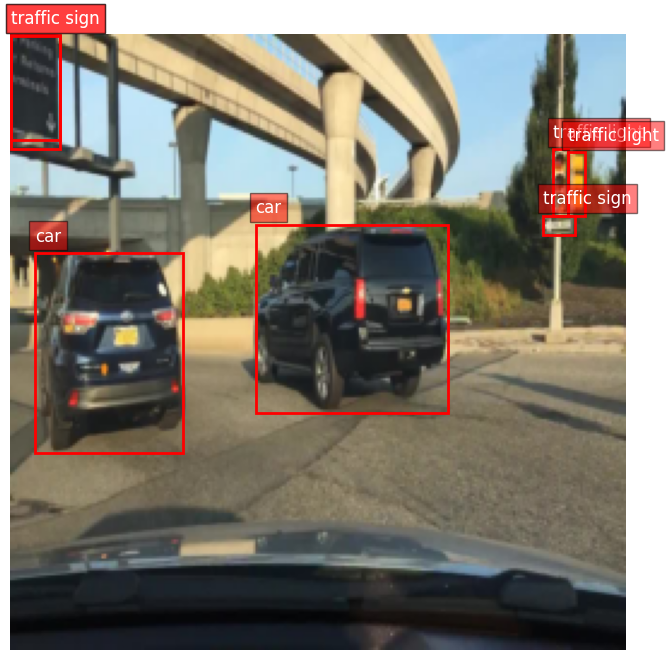

In [7]:
# Get first batch & display sample
for X, y in test_dataloader:
    print(f"\nBatch information:")
    print(f"Number of images in batch: {len(X)}")
    print(f"Shape of processed image tensor [C,H,W]: {X[0].shape}")
    
    # Get original size from first image in batch
    original_width, original_height = y[0]['original_size']
    print(f"Original image size: {original_width}x{original_height}")
    
    # Display ground truths for first image
    print(f"\nGround truths for first image:")
    print(f"Number of objects: {len(y[0]['boxes'])}")
    print("Bounding boxes (x1, y1, x2, y2):")
    for i, (box, label) in enumerate(zip(y[0]['boxes'], y[0]['labels'])):
        print(f"Object {i+1}:")
        print(f"  Category: {label}")
        print(f"  Box coordinates: {box.tolist()}")

    show_sample_with_boxes(X[0], y[0])  # Show first image with bounding boxes
    break

